Libraries:

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import json
import folium as folium
from wordcloud import WordCloud

Libraries for keyword selection:

In [3]:
!pip install google_trans_new

  Using cached google_trans_new-1.1.9-py3-none-any.whl (9.2 kB)


In [4]:
import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from google_trans_new import google_translator 
from pytrends.request import TrendReq

# I. Keywords Selection

## a. Text processing to get the most common keywords

Open the data.txt where the tourism articles has been concatenated:

In [7]:
f = open("./data/data.txt", "r")
data = f.read()
f.close()

In [8]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

In [9]:
df = pd.DataFrame([remove_punctuation(line) for line in data.split("\n") if line])
df.columns = ["lines"]

In [10]:
df

,lines
0,Switzerland is home to seemingly endless natur...
1,Lake Geneva
2,One of the largest lakes in Western Europe Lak...
3,The Lion of Lucerne
4,In 1792 members of the Swiss Guard were massac...
...,...
1498,lausanne places to visit in switzerland
1499,50 Visit picturesque Albogasio
1500,While this picturesque village is technically ...
1501,things to do in switzerland


In [11]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
df['lines']=df['lines'].apply(lambda x: tokenize(x.lower()))
df.head()

,lines
0,"[switzerland, is, home, to, seemingly, endless..."
1,"[lake, geneva]"
2,"[one, of, the, largest, lakes, in, western, eu..."
3,"[the, lion, of, lucerne]"
4,"[in, 1792, members, of, the, swiss, guard, wer..."


In [12]:
stopword = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
def remove_stopwords_plus_stem(text):
    text=[ps.stem(word) for word in text if word not in stopword]
    return text
df['lines'] = df['lines'].apply(lambda x: remove_stopwords_plus_stem(x))
df.head()

,lines
0,"[switzerland, home, seemingli, endless, natur,..."
1,"[lake, geneva]"
2,"[one, largest, lake, western, europ, lake, gen..."
3,"[lion, lucern]"
4,"[1792, member, swiss, guard, massacr, french, ..."


In [13]:
from collections import defaultdict
word_count = defaultdict(int)

def count_words(text):
    for word in text:
        word_count[word]+=1
    return None

df["lines"].apply(lambda x: count_words(x))
word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}
word_count_df = pd.DataFrame(word_count, index=["count"]).transpose().head(50)
word_count_df

,count
,408
switzerland,312
lake,163
one,151
swiss,147
citi,117
mountain,117
town,108
take,106
visit,101


## b. Choose a keyword list and get the translations

In [14]:
translator = google_translator()  
translate_text = translator.translate('keyboard',lang_tgt='fr')  
print(translate_text)

clavier 


In [15]:
pytrends = TrendReq(hl='fr-FR', tz=360)

In [16]:
kw_list = ["swiss " + word for word in list(word_count_df.index[5:10])]
kw_list = ["Hotel Switzerland","travel Switzerland", "Visit Switzerland", "lake Switzerland", "Geneva"]

In [17]:
language_list = ["en","fr","de","ja","de"]
lang_dict = {
    "US": "en",
    "FR": "fr",
    "DE": "de",
    "JP": "ja",
    "CH": "de"
}
print(lang_dict["JP"])

ja


In [18]:
kw_dict = {}
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    kw_list_coutry = []
    for kw in kw_list:
        kw_list_coutry.append( translator.translate(kw,lang_tgt=lang_dict[country]) )
    kw_dict[country] = kw_list_coutry
    print(kw_dict[country])
print(kw_dict)


['Hotel Switzerland ', 'travel Switzerland ', 'Visit Switzerland ', 'lake Switzerland ', 'Geneva ']
['Hôtel Suisse ', 'voyage en Suisse ', 'Visiter la Suisse ', 'lac Suisse ', 'Genève ']
['Hotel Schweiz ', 'Reise Schweiz ', 'Besuchen Sie die Schweiz ', 'See Schweiz ', 'Genf ']
['ホテルスイス ', '旅行スイス ', 'スイスを訪問 ', 'スイス湖 ', 'ジュネーブ ']
['Hotel Schweiz ', 'Reise Schweiz ', 'Besuchen Sie die Schweiz ', 'See Schweiz ', 'Genf ']
{'US': ['Hotel Switzerland ', 'travel Switzerland ', 'Visit Switzerland ', 'lake Switzerland ', 'Geneva '], 'FR': ['Hôtel Suisse ', 'voyage en Suisse ', 'Visiter la Suisse ', 'lac Suisse ', 'Genève '], 'DE': ['Hotel Schweiz ', 'Reise Schweiz ', 'Besuchen Sie die Schweiz ', 'See Schweiz ', 'Genf '], 'JP': ['ホテルスイス ', '旅行スイス ', 'スイスを訪問 ', 'スイス湖 ', 'ジュネーブ '], 'CH': ['Hotel Schweiz ', 'Reise Schweiz ', 'Besuchen Sie die Schweiz ', 'See Schweiz ', 'Genf ']}


## c. Get and plot the Trends Time series

In [19]:
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    print(lc)

en-US
fr-FR
de-DE
ja-JP
de-CH


In [20]:
dfs = {}
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    pytrends = TrendReq(hl=lc, tz=360)
    pytrends.build_payload(kw_dict[country], cat=0, timeframe='today 5-y', geo=country, gprop='')
    dfs[country] = pytrends.interest_over_time()

In [21]:
dfs

{'US':             Hotel Switzerland   travel Switzerland   Visit Switzerland   \
 date                                                                      
 2015-12-20                   0                    0                   0   
 2015-12-27                   1                    1                   0   
 2016-01-03                   0                    0                   0   
 2016-01-10                   1                    1                   0   
 2016-01-17                   1                    0                   0   
 ...                        ...                  ...                 ...   
 2020-11-08                   0                    1                   0   
 2020-11-15                   0                    0                   0   
 2020-11-22                   1                    0                   0   
 2020-11-29                   0                    0                   0   
 2020-12-06                   0                    0                   0   
 
    

In [22]:
import matplotlib.pyplot as plt

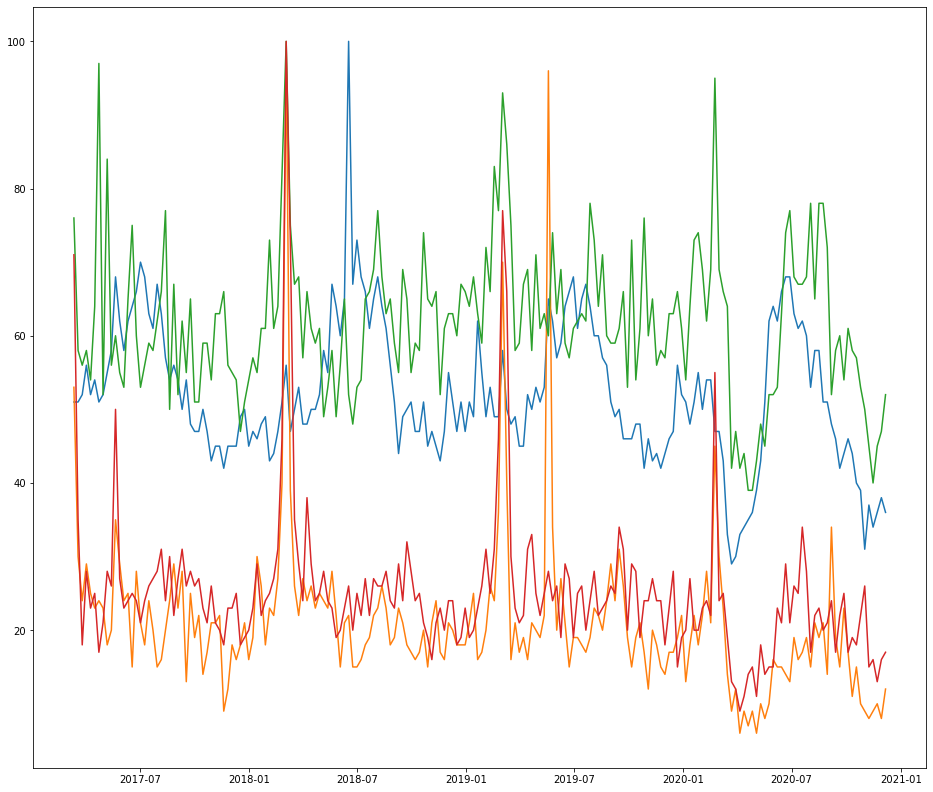

In [23]:
fig = plt.figure(figsize=(16,14))
plt.plot(dfs["US"].index[-196:], dfs["US"][kw_dict["US"][4]][-196:])
plt.plot(dfs["DE"].index[-196:], dfs["DE"][kw_dict["DE"][4]][-196:])
plt.plot(dfs["FR"].index[-196:], dfs["FR"][kw_dict["FR"][4]][-196:])
plt.plot(dfs["CH"].index[-196:], dfs["CH"][kw_dict["CH"][4]][-196:])
plt.show()
#plt.plot(dfs["DE"]["swiss mountain"])

# Data Processing

In [24]:
# Loading the data (from Jan 2009 to December 2020)
data = pd.read_csv('data/Tourism.csv', delimiter=';', header=1)

In [25]:
data.head(5)

,Year,Month,Canton,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
0,2009,January,Switzerland,1064111,528523,1250,154530,44363,38939,10142,...,...,919,963,1955,21566,644,638,1885,2623,...
1,2009,February,Switzerland,1089483,521069,864,160914,59787,35721,10615,...,...,779,728,1657,9881,920,595,2435,1328,...
2,2009,March,Switzerland,1196859,567431,1290,187297,55015,43895,14476,...,...,964,965,2010,13485,1123,780,3676,1839,...
3,2009,April,Switzerland,1045137,468308,1671,164642,48102,38747,13328,...,...,916,1010,1750,9139,1491,1073,3029,1341,...
4,2009,May,Switzerland,1214666,548389,1120,183987,52869,40187,16379,...,...,919,903,1638,13502,1014,847,3823,1690,...


In [26]:
#Reindexing
data.index = pd.date_range('2009-01-01', '2020-12-01', freq= 'MS')

In [27]:
#Drop useless columns
data = data.drop(['Year', 'Month', 'Canton'], axis = 1)

In [28]:
#Replacing '...' values by 0 and Converting arrival string values into integer values
for column in data.columns:
    data[column] = data[column].apply(lambda x : 0 if x == '...' else float(x))

In [29]:
#Reformatting column names 
f = lambda x: x[: -(len(x.split()[-1])+1)]
data.columns =  [f(x) for x in data.columns]

In [30]:
# Selecting the corona period of every year 
corona_periods = pd.date_range(f'2009-01-01', periods=5 , freq = 'MS')
for i in range(2010, 2021):
    corona_periods = corona_periods.append(pd.date_range(f'{i}-01-01', periods= 5, freq = 'MS'))

corona_yearly_periods = data.loc[corona_periods]

In [31]:
corona_period_germany_2018 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2018-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2019 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2019-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2020 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2020-01-01', periods= 5, freq = 'MS')]


In [32]:
data.head(3)

,Visitors' country of residence - total,Switzerland,Baltic States,Germany,France,Italy,Austria,United Kingdom,Irland,Netherlands,...,United Arab Emirates,Serbia and Montenegro,Croatia,Romania,Russia,Slovakia,Slovenia,Czechia,Ukraine,Serbia
2009-01-01,1064111.0,528523.0,1250.0,154530.0,44363.0,38939.0,10142.0,53636.0,2662.0,20687.0,...,0.0,919.0,963.0,1955.0,21566.0,644.0,638.0,1885.0,2623.0,0.0
2009-02-01,1089483.0,521069.0,864.0,160914.0,59787.0,35721.0,10615.0,65594.0,2880.0,39239.0,...,0.0,779.0,728.0,1657.0,9881.0,920.0,595.0,2435.0,1328.0,0.0
2009-03-01,1196859.0,567431.0,1290.0,187297.0,55015.0,43895.0,14476.0,61323.0,2744.0,24138.0,...,0.0,964.0,965.0,2010.0,13485.0,1123.0,780.0,3676.0,1839.0,0.0


In [33]:
#Taking the median per year for every country
total_arrivals_per_country =  data.groupby(data.index.map(lambda x : x.year)).median().T
total_arrivals_per_country_during_corona = corona_yearly_periods.groupby(corona_yearly_periods.index.map(lambda x : x.year)).median().T


In [34]:
total_arrivals_per_country.head(3)

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Visitors' country of residence - total,1205762.5,1269687.5,1270058.5,1303630.5,1326127.0,1376105.5,1367459.5,1403172.5,1463063.5,1542019.5,1569376.0,832943.5
Switzerland,557910.0,580441.5,588889.0,616644.5,615355.5,642263.5,636332.5,668932.5,685699.0,719934.5,736524.5,644719.0
Baltic States,1270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def remove_useless_select_year_and_sort(data, year, normalize = False):
    final = pd.DataFrame(data.drop(["Visitors' country of residence - total", 'Switzerland'], axis = 0)[year])\
                                    .sort_values(by= [year], ascending=False)\
                                    .reset_index().rename(columns={'index':'Country', year : 'Arrivals'}, inplace=False)
    return final

In [36]:
total_arrivals_per_country_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2018)
total_arrivals_per_country_during_corona_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona_period, 2018)
total_arrivals_per_country_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2020)
total_arrivals_per_country_during_corona_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona_period, 2020)


NameError: name 'total_arrivals_per_country_during_corona_period' is not defined

In [37]:
total_arrivals_per_country_2018

,Country,Arrivals
0,Germany,135259.5
1,China,82211.0
2,United States,70335.5
3,United Kingdom,58511.5
4,France,57899.5
...,...,...
71,Gulf States,0.0
72,"Australia, New Zealand, Oceania",0.0
73,Serbia and Montenegro,0.0
74,"Central America, Caribbean",0.0


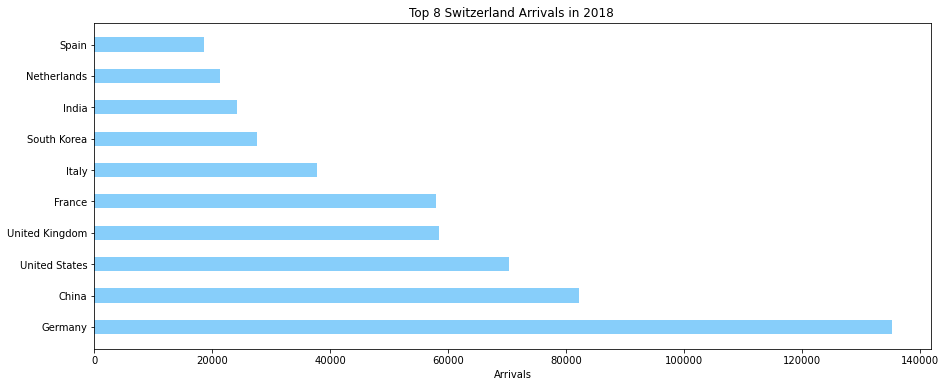

In [38]:
fig, ax = plt.subplots(figsize = (15, 6))

ind = np.arange(10)    # the x locations for the groups
width = 0.45       # the width of the bars


p1 = ax.barh(width/2 + ind, total_arrivals_per_country_2018['Arrivals'][:10], width, color = 'lightskyblue')#, yerr=err(median_sugar_switzerland))

ax.set_title('Top 8 Switzerland Arrivals in 2018 ')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(total_arrivals_per_country_2018['Country'][:10])

ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Top_8_Arrivals_2018.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

In [39]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11,6)})
sns.set(style='whitegrid')
sns.barplot(x='Arrivals' , y='Country', data = total_arrivals_per_country_2018[:8], orient='h')

ModuleNotFoundError: No module named 'seaborn'

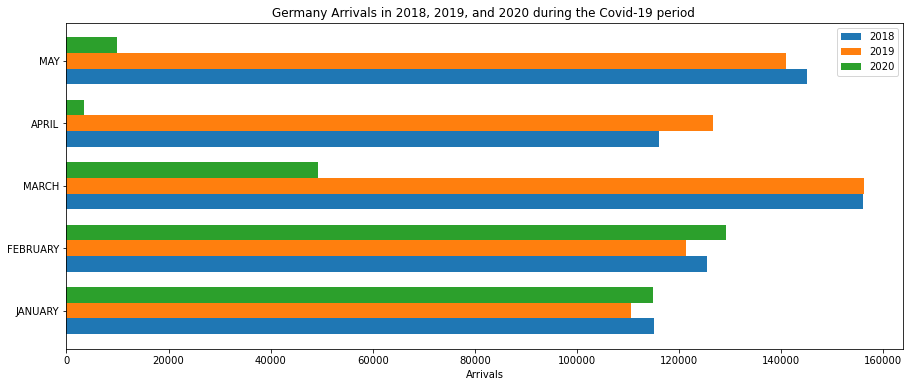

In [40]:
fig, ax = plt.subplots(figsize = (15, 6))

ind = np.arange(5)    # the x locations for the groups
width = 0.25       # the width of the bars


p1 = ax.barh(ind - width, corona_period_germany_2018[:5], width)
p2 = ax.barh(ind ,corona_period_germany_2019[:5], width)
p3 = ax.barh(ind + width,corona_period_germany_2020[:5], width)

ax.set_title('Germany Arrivals in 2018, 2019, and 2020 during the Covid-19 period ')
ax.set_yticks(ind)
ax.set_yticklabels(np.array(['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY']))


ax.legend((p1[0], p2[0], p3[0]), ('2018', '2019', '2020'))
ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Germany_Arrivals_Covid_Period.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

In [41]:
# this file contains topologies for all countries in the world_map
world_map = './data/world-countries.json'
json_object = json.load(open(world_map))

## Ckeck arrivals to Switzerland by country in 2018

In [42]:
for feature in json_object['features']:
    country = feature['properties']['name']
    if country not in total_arrivals_per_country_2018.Country.values:
        df =  pd.DataFrame({'Country': country, 'Arrivals': 0}, index = np.arange(1))
        total_arrivals_per_country_2018 = pd.concat([total_arrivals_per_country_2018 ,df])


In [43]:
map = folium.Map(location=[20, 0], zoom_start=2)

map.choropleth(geo_data=world_map, data=total_arrivals_per_country_2018,
             columns=['Country', 'Arrivals'],
             key_on='feature.properties.name',
             fill_color='BuGn')


map

/Users/vincentnaayem/anaconda3/envs/ADA_Project/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [44]:
#Plot total number of Arrivals from Jan 2009 to March 2020 (Lockdown in Switzerland)
plt.figure(figsize= (19,6 ))
plt.plot(data[:datetime(2020,3,1)].index, data["Visitors' country of residence - total Arrivals"][:datetime(2020,3,1)], color = 'orange')
plt.plot(data[datetime(2020,2,1):datetime(2020,3,1)].index, data["Visitors' country of residence - total Arrivals"][datetime(2020,2,1):datetime(2020,3,1)], color = 'r')
plt.title('Total Arrivals in Switzerland from 2009 to 2020')
plt.xlabel('Time')
plt.ylabel('Arrivals')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

KeyError: "Visitors' country of residence - total Arrivals"

<Figure size 1368x432 with 0 Axes>

## AR Base Modelisation

/Users/vincentnaayem/anaconda3/envs/ADA_Project/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


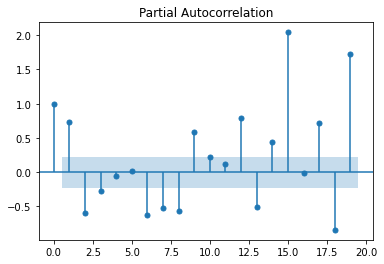

In [45]:
#Covid crisis for our testSet
start_date_testing = datetime(2015,3,1)
end_date_testing = datetime(2020,10,1)

Arrivals = pd.DataFrame(data["Visitors' country of residence - total"])
Arrivals = Arrivals.rename(columns = {"Visitors' country of residence - total": 'Total Arrivals'}, inplace = False)
#Arrivals['Total Arrivals'] = Arrivals['Total Arrivals'].apply(lambda x : np.log(x) if x>0 else 0)

pacf = plot_pacf(Arrivals['Total Arrivals'][:start_date_testing])

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values: it describes how well the present value of the series is related with its past values.


PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

We observe a significant partial correlation with variables in delays list below

In [46]:
lags = {1:'t-1', 2:'t-2', 12:'t-12', 15:'t-15', 17:'t-17', 18:'t-18', 19:'t-19' }

for lag in lags:
    Arrivals[f"t-{lag}"] = Arrivals['Total Arrivals'].shift(lag)

Arrivals = Arrivals.dropna(axis=0)

In [47]:
Arrivals.head(4)

,Total Arrivals,t-1,t-2,t-12,t-15,t-17,t-18,t-19
2010-08-01,1887475.0,1955557.0,1556381.0,1876038.0,1214666.0,1196859.0,1089483.0,1064111.0
2010-09-01,1677924.0,1887475.0,1955557.0,1621888.0,1446249.0,1045137.0,1196859.0,1089483.0
2010-10-01,1317370.0,1677924.0,1887475.0,1267800.0,1821751.0,1214666.0,1045137.0,1196859.0
2010-11-01,927559.0,1317370.0,1677924.0,880617.0,1876038.0,1446249.0,1214666.0,1045137.0


In [48]:
True_Arrivals = Arrivals['Total Arrivals'][start_date_testing : end_date_testing]

In [49]:
Hotels = pd.read_csv('data/Hotel.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Hotels = Hotels.rename(columns = {'Hotel: (Suisse)' : 'Switzerland_Hotels_Trend'})
Airbnb = pd.read_csv('data/Airbnb.csv', header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Airbnb = Airbnb.rename(columns = {'airbnb: (France)' : 'France_Airbnb_Trend'})
Covid_19 = pd.read_csv('data/Covid19.csv', header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Covid_19 = Covid_19.rename(columns = {'covid19: (Switzerland)' : 'Covid_19_France'})

In [50]:
Airbnb['France_Airbnb_Trend'] = Airbnb['France_Airbnb_Trend'].apply(lambda x : 0 if x == '<\xa01'else float(x))

In [51]:
Covid_19

,Covid_19_France
Month,
2009-01-01,0
2009-02-01,0
2009-03-01,0
2009-04-01,0
2009-05-01,0
...,...
2020-08-01,22
2020-09-01,19
2020-10-01,24


In [52]:
r = np.corrcoef(Arrivals['Total Arrivals'].values, Hotels.loc[Arrivals.index].values.reshape((1,-1))[0])

In [53]:
#Correlation Coeff between Hotels Trend and True Arrivals 
r[0][1]

0.8088484677811733

In [54]:
Arrivals = pd.merge(Arrivals, Hotels, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Airbnb, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Covid_19, right_index = True, left_index=True)


In [55]:
Arrivals

,Total Arrivals,t-1,t-2,t-12,t-15,t-17,t-18,t-19,Switzerland_Hotels_Trend,France_Airbnb_Trend,Covid_19_France
2010-08-01,1887475.0,1955557.0,1556381.0,1876038.0,1214666.0,1196859.0,1089483.0,1064111.0,94,0.0,0
2010-09-01,1677924.0,1887475.0,1955557.0,1621888.0,1446249.0,1045137.0,1196859.0,1089483.0,85,0.0,0
2010-10-01,1317370.0,1677924.0,1887475.0,1267800.0,1821751.0,1214666.0,1045137.0,1196859.0,78,0.0,0
2010-11-01,927559.0,1317370.0,1677924.0,880617.0,1876038.0,1446249.0,1214666.0,1045137.0,66,0.0,0
2010-12-01,1054278.0,927559.0,1317370.0,1039895.0,1621888.0,1821751.0,1446249.0,1214666.0,61,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,2270490.0,1624902.0,1526592.0,1332892.0,1226739.0,76,82.0,22
2020-09-01,1291992.0,1525425.0,1539928.0,1958831.0,2006805.0,1384180.0,1526592.0,1332892.0,72,46.0,19
2020-10-01,949466.0,1291992.0,1525425.0,1612160.0,2284423.0,1624902.0,1384180.0,1526592.0,52,37.0,24
2020-11-01,0.0,949466.0,1291992.0,1154630.0,2270490.0,2006805.0,1624902.0,1384180.0,33,20.0,19


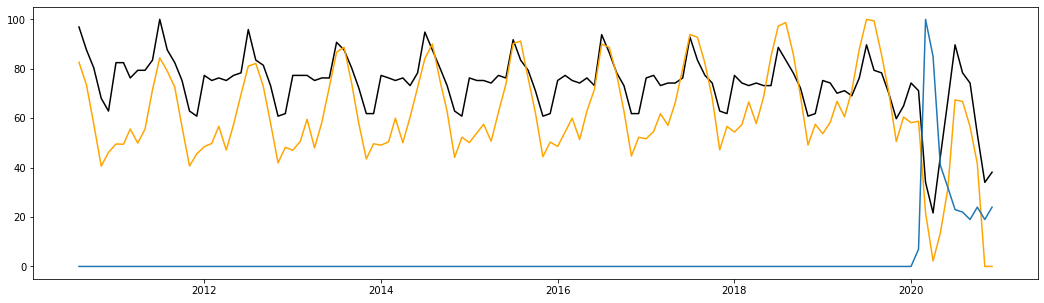

In [56]:
#Hotel plot
fig,axes = plt.subplots(figsize=(18,5))
axes.plot((Arrivals['Switzerland_Hotels_Trend']*100)/max(Arrivals['Switzerland_Hotels_Trend']), label = 'Actual',color = 'k')
axes.plot((Arrivals['Total Arrivals']*100)/max(Arrivals['Total Arrivals']), label = 'Actual',color = 'orange')
axes.plot((Arrivals['Covid_19_France']*100)/max(Arrivals['Covid_19_France']), label = 'Actual')

In [57]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration

def Auto_Regressive_Model(True_Labels, end_date_testing, dataset, lags, trends, with_trends=False):
    
    Arrivals_Predictions = True_Labels.copy()

    if (with_trends):
        lags.extend(trends)
        
    for train_last in True_Arrivals.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
        
        X_train = train[lags].values
        X_test = test[lags].values
        
            
        y_train = train['Total Arrivals'].values
        y_test = test['Total Arrivals'].values
        
    
        lr = LinearRegression()
    
        lr.fit(X_train, y_train)
        
            
        if(train_last==start_date_testing):
            print('The intercept value is:', lr.intercept_ )
            for i, lag in enumerate(lags):
                print('The final estimation of {} is: {}'.format(lag, lr.coef_[i]))
        
        pred = lr.predict(X_test)
    
        Arrivals_Predictions[train_last] = pred[0]
        
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE) )
    
    return Arrivals_Predictions, MAE

In [58]:
lags_1 = ['t-1', 't-2', 't-12', 't-15', 't-17', 't-18','t-19']
lags_2 = ['t-1', 't-2', 't-15', 't-17', 't-18', 't-19']
lags_3 = ['t-1']

trends = [ "Switzerland_Hotels_Trend", "Covid_19_France"]

In [59]:
Baseline_Arrivals_Predictions_1, Baseline_MAE_1= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = False)




The intercept value is: 95699.80661898619
The final estimation of t-1 is: 0.030009425024571525
The final estimation of t-2 is: 0.04479499803943534
The final estimation of t-12 is: 0.9374097852741435
The final estimation of t-15 is: -0.06298791918931751
The final estimation of t-17 is: 0.0329810691433627
The final estimation of t-18 is: -0.018473606478940818
The final estimation of t-19 is: -0.019485902119822183
MAE :95071.0041853863


In [60]:
Baseline_Arrivals_Predictions_2, Baseline_MAE_2 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = False)


The intercept value is: 1800331.7911818312
The final estimation of t-1 is: 0.7071095660668056
The final estimation of t-2 is: 0.026450529933775304
The final estimation of t-15 is: -0.7123525500512277
The final estimation of t-17 is: 0.23155812639444945
The final estimation of t-18 is: -0.11060558896220654
The final estimation of t-19 is: -0.46952953180080576
MAE :163398.20550977296


In [61]:
Baseline_Arrivals_Predictions_3, Baseline_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                    lags_3.copy(),\
                                                    trends.copy(), with_trends = False)


The intercept value is: 374676.6107534823
The final estimation of t-1 is: 0.7211413713275944
MAE :224826.27698392092


In [62]:
Trends_Arrivals_Predictions_1, Trend_MAE_1 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: 234396.12708243844
The final estimation of t-1 is: 0.06927055259180474
The final estimation of t-2 is: 0.027350764586416887
The final estimation of t-12 is: 0.9509960386966201
The final estimation of t-15 is: -0.08971339383140951
The final estimation of t-17 is: 0.03934895475806545
The final estimation of t-18 is: -0.02510218714309721
The final estimation of t-19 is: -0.020721475491262808
The final estimation of Switzerland_Hotels_Trend is: -1984.1962894533724
The final estimation of Covid_19_France is: 0.0
MAE :76702.27198365968


In [63]:
Trends_Arrivals_Predictions_2, Trend_MAE_2 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: 1357677.3644670148
The final estimation of t-1 is: 0.5741671143076812
The final estimation of t-2 is: 0.07442696992256524
The final estimation of t-15 is: -0.6144579752509071
The final estimation of t-17 is: 0.20651099492499073
The final estimation of t-18 is: -0.08903152931786984
The final estimation of t-19 is: -0.4485125785233978
The final estimation of Switzerland_Hotels_Trend is: 5375.16083177827
The final estimation of Covid_19_France is: 0.0
MAE :169974.9376190523


In [64]:
Trends_Arrivals_Predictions_3, Trend_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_3.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: -678767.4202499401
The final estimation of t-1 is: 0.4188519650011774
The final estimation of Switzerland_Hotels_Trend is: 19674.77812973264
The final estimation of Covid_19_France is: 0.0
MAE :171995.77610448623


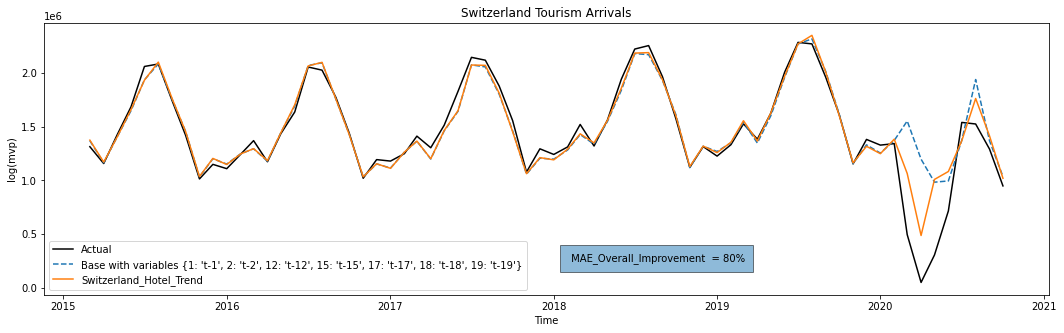

In [65]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_1, linestyle='dashed', label='Base with variables {}'.format(lags))
axes.plot(Trends_Arrivals_Predictions_1, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int((Trend_MAE_1 * 100) /Baseline_MAE_1)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

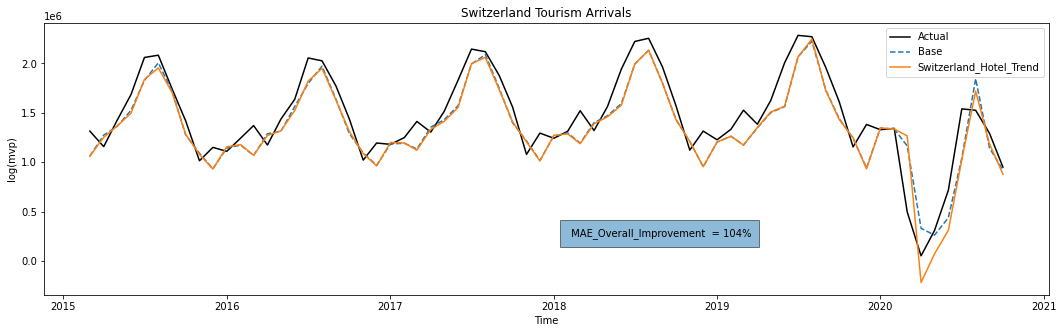

In [66]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_2, linestyle='dashed', label='Base')
axes.plot(Trends_Arrivals_Predictions_2, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int((Trend_MAE_2 * 100) /Baseline_MAE_2)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

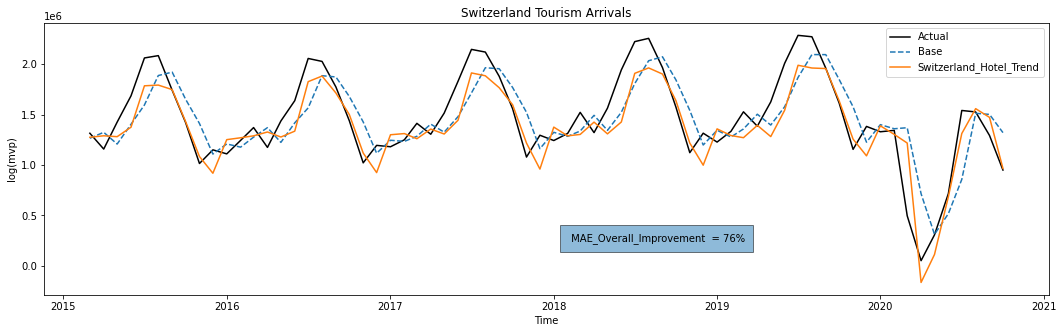

In [67]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_3, linestyle='dashed', label='Base')
axes.plot(Trends_Arrivals_Predictions_3, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int((Trend_MAE_3 * 100) /Baseline_MAE_3)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()